# Improving Flu Vaccination Rates with a Targeted Outreach Program

Lovelace Health, a Federally Qualified Health Center, wishes to increase the proportion of its patients who receive the flu vaccine.  The Health Center plans to reach out to individual patients by phone to encourage them to schedule their vaccine appointments.

In addition to targeting those most at risk of complications from the flu, the health center hopes to reach out to those who are least likely to get the vaccine, in order to boost immunity in its patient population generally.

My task is to build a model that can use the patient health and demographic data Lovelace already has on file to predict which patients are unlikely to get the vaccine.

## Data Understanding

To build the model, I used data from the [National 2009 H1N1 Flu Survey](https://www.cdc.gov/nchs/nis/data_files_h1n1.htm), a government-sponsored telephone survey designed to monitor vaccination rates for both flu and H1N1 during the 2009-10 season. Specifically, I used the data as curated by DrivenData for its [Flu Shot Learning](https://www.drivendata.org/competitions/66/flu-shot-learning/) competition.

For this problem, I used only data that a community health center would store in its electronic health record, although the survey results also contained information about health-related opinions and behaviors.  Additionally, although the results show whether each respondent received both the flu and H1N1 vaccines, for this exercise I focused on predicting only flu vaccine status.

The data contain over 20,000 survey responses from Americans aged 18 and over, and show that about 47% of respondents received the flu vaccine.  The data include variables showing each respondent's age, sex, race, marital status, geographic location, health insurance status, and occupation.  They also show whether the respondent had a chronic health condition and whether their doctor recommended the flu vaccine. Several columns have a small amount of null values, and about half the values are null in the occupation and insurance status columns.

Demographic categories in the data are not quite representative of the U.S. population at the time.  For example, 59% of respondents were women, and the age of respondents was skewed toward older demographics.  Additionally, 79% of survey respondents were white while only 72% of the population identified as white on the 2010 census.  Only 8% and 7% of survey respondents identified as black and Hispanic respectively; in contrast the [2010 census](https://www.census.gov/newsroom/releases/archives/2010_census/cb11-cn125.html) proportions were 13% and 16%.  The large discrepancy in the proportions of people identifying as Hispanic is partly explained by the fact that the census treated Hispanic/non-Hispanic as an ethnicity and not a race, while the survey did not.  These discrepancies imply we should be skeptical of drawing conclusions based on race.

Finally, in order to protect the identities of respondents, the names of geographic regions and occupations have all been scrambled.  This is also the reason why races other than white, black, and Hispanic have been lumped into the 'Other or Multiple' category - these groups are so small that separating them might compromise respondent privacy.

## Data Preparation

In [3]:
# import packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, plot_roc_curve, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import utils as ut

In [4]:
# import predictors (data) and target (labels)

data = pd.read_csv('data/training_set_features.csv')
labels = pd.read_csv('data/training_set_labels.csv')

In [5]:
data

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,3.00000,1.00000,2.00000,2.00000,1.00000,2.00000,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.00000,0.00000,NaN,NaN
1,1,3.00000,2.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,5.00000,4.00000,4.00000,4.00000,2.00000,4.00000,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.00000,0.00000,pxcmvdjn,xgwztkwe
2,2,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,nan,1.00000,0.00000,0.00000,nan,3.00000,1.00000,1.00000,4.00000,1.00000,2.00000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.00000,0.00000,rucpziij,xtkaffoo
3,3,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,nan,3.00000,3.00000,5.00000,5.00000,4.00000,1.00000,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.00000,0.00000,NaN,NaN
4,4,2.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,3.00000,3.00000,2.00000,3.00000,1.00000,4.00000,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.00000,0.00000,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,3.00000,1.00000,1.00000,5.00000,2.00000,2.00000,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.00000,0.00000,NaN,NaN
26703,26703,1.00000,2.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,4.00000,2.00000,2.00000,5.00000,1.00000,1.00000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.00000,0.00000,fcxhlnwr,cmhcxjea
26704,26704,2.00000,2.00000,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,4.00000,4.00000,2.00000,5.00000,4.00000,2.00000,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.00000,0.00000,NaN,NaN
26705,26705,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,1.00000,2.00000,2.00000,1.00000,2.00000,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.00000,0.00000,fcxhlnwr,haliazsg


In [6]:
labels

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


**Define Predictors and Target**

In [7]:
# define X (predictors) and y (target)
# keep only predictors which a health center would have on file
# use seasonal flu vaccine outcome as target (disregard H1N1)

X = data.drop(columns=['h1n1_concern',
                       'h1n1_knowledge',
                       'behavioral_antiviral_meds',
                       'behavioral_avoidance',
                       'behavioral_face_mask',
                       'behavioral_wash_hands',
                       'behavioral_large_gatherings',
                       'behavioral_outside_home',
                       'behavioral_touch_face',
                       'doctor_recc_h1n1',
                       'child_under_6_months',
                       'opinion_h1n1_vacc_effective',
                       'opinion_h1n1_risk',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_h1n1_sick_from_vacc',
                       'opinion_seas_vacc_effective',
                       'opinion_seas_risk',
                       'opinion_seas_sick_from_vacc',
                       'education',
                       'income_poverty',
                       'rent_or_own',
                       'household_adults',
                       'household_children'])

y = labels['seasonal_vaccine']

In [8]:
X

,respondent_id,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


**Column descriptions from DrivenData:**

* respondent_id - a unique and random identifier
* doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. (binary)
* doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor. (binary)
* chronic_med_condition - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)
* health_worker - Is a healthcare worker. (binary)
* health_insurance - Has health insurance. (binary)
* age_group - Age group of respondent.
* race - Race of respondent.
* sex - Sex of respondent.
* marital_status - Marital status of respondent.
* employment_status - Employment status of respondent.
* hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
* census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
* employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
* employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

In [9]:
# eliminate id column, which is the same as index number

X.drop(columns='respondent_id', inplace=True)
X

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,0.00000,0.00000,0.00000,1.00000,55 - 64 Years,White,Female,Not Married,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,0.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Male,Not Married,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,nan,1.00000,0.00000,nan,18 - 34 Years,White,Male,Not Married,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,0.00000,0.00000,0.00000,nan,45 - 54 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.00000,0.00000,0.00000,nan,65+ Years,White,Female,Not Married,Not in Labor Force,qufhixun,Non-MSA,NaN,NaN
26703,1.00000,0.00000,1.00000,1.00000,18 - 34 Years,White,Male,Not Married,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,0.00000,0.00000,0.00000,nan,55 - 64 Years,White,Female,Not Married,NaN,lzgpxyit,"MSA, Not Principle City",NaN,NaN
26705,0.00000,0.00000,0.00000,0.00000,18 - 34 Years,Hispanic,Female,Married,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


**Train-Test Split**

In [10]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**Data Exploration**

In [11]:
# no class imbalance in target

y_train.value_counts()
# y_train.describe()  # mean is 0.46

0    10716
1     9314
Name: seasonal_vaccine, dtype: int64

In [12]:
# explore variables

X_train
X_train.describe()
X_train.info()

# many nulls
# many categorical columns --> need to encode

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 15266 to 1145
Data columns (total 13 columns):
doctor_recc_seasonal     18399 non-null float64
chronic_med_condition    19286 non-null float64
health_worker            19403 non-null float64
health_insurance         10806 non-null float64
age_group                20030 non-null object
race                     20030 non-null object
sex                      20030 non-null object
marital_status           18931 non-null object
employment_status        18890 non-null object
hhs_geo_region           20030 non-null object
census_msa               20030 non-null object
employment_industry      10042 non-null object
employment_occupation    9939 non-null object
dtypes: float64(4), object(9)
memory usage: 2.1+ MB


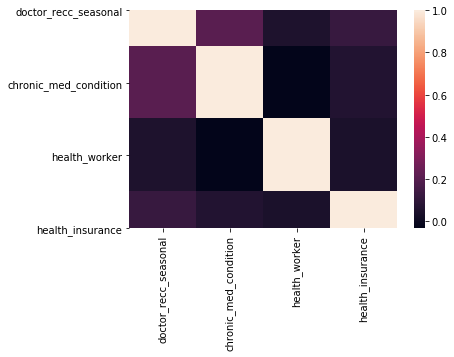

In [13]:
# heatmap shows few correlations due to high number of nulls and categorical columns

corr = X_train.corr()
sns.heatmap(corr)

In [14]:
# explore 'race' proportions for comparison to 2010 census data

X_train['race'].value_counts()/len(X_train)

# race proportions are different from 2010 census data - see Data Understanding above

White               0.79656
Black               0.07828
Hispanic            0.06590
Other or Multiple   0.05926
Name: race, dtype: float64

In [15]:
# show per cent nulls by column
# about half of data is missing for health_insurance, employment_industry, employment_occupation

round((X_train.isna().sum()*100/len(X_train)),2)

doctor_recc_seasonal     8.14000
chronic_med_condition    3.71000
health_worker            3.13000
health_insurance        46.05000
age_group                0.00000
race                     0.00000
sex                      0.00000
marital_status           5.49000
employment_status        5.69000
hhs_geo_region           0.00000
census_msa               0.00000
employment_industry     49.87000
employment_occupation   50.38000
dtype: float64

In [16]:
# look at value counts - see if there is an obvious choice to impute for nulls
# see if there are any very small categories - looks like some employment categories are very small

for c in X_train.columns:
    print(X_train[c].value_counts())
    
# most ppl have health insurance, I can create a new column to indicate which rows are missing this info
# employment industry and occupation - when encoded, nulls will be ignored

0.00000    12305
1.00000     6094
Name: doctor_recc_seasonal, dtype: int64
0.00000    13846
1.00000     5440
Name: chronic_med_condition, dtype: int64
0.00000    17217
1.00000     2186
Name: health_worker, dtype: int64
1.00000    9521
0.00000    1285
Name: health_insurance, dtype: int64
65+ Years        5125
55 - 64 Years    4152
18 - 34 Years    3966
45 - 54 Years    3917
35 - 44 Years    2870
Name: age_group, dtype: int64
White                15955
Black                 1568
Hispanic              1320
Other or Multiple     1187
Name: race, dtype: int64
Female    11865
Male       8165
Name: sex, dtype: int64
Married        10122
Not Married     8809
Name: marital_status, dtype: int64
Employed              10183
Not in Labor Force     7585
Unemployed             1122
Name: employment_status, dtype: int64
lzgpxyit    3194
fpwskwrf    2462
qufhixun    2338
kbazzjca    2176
oxchjgsf    2162
bhuqouqj    2115
mlyzmhmf    1661
atmpeygn    1541
lrircsnp    1525
dqpwygqj     856
Name: hhs_geo_

In [17]:
# create bar graphs to explore interactions between variables
# create new df X_train_plot to contain a numeric age column for plotting

X_train_plot=X_train.copy()
X_train_plot['age_group_num'] = X_train_plot['age_group'].apply(lambda x: 1 if (x == '18 - 34 Years')
                                                        else 2 if (x == '35 - 44 Years')
                                                        else 3 if (x == '45 - 54 Years')
                                                        else 4 if (x == '55 - 64 Years')
                                                        else 5)

In [18]:
# concatenate X_train_plot and y_train to create a df for plotting bar graphs

train_to_plot = pd.concat([X_train_plot, y_train], axis=1).drop(columns='age_group')
train_to_plot

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,age_group_num,seasonal_vaccine
15266,1.00000,1.00000,0.00000,1.00000,White,Female,Not Married,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",NaN,NaN,5,0
17217,1.00000,1.00000,0.00000,nan,White,Female,Married,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",NaN,NaN,5,1
19265,0.00000,1.00000,0.00000,1.00000,White,Female,Married,Employed,oxchjgsf,"MSA, Principle City",arjwrbjb,xtkaffoo,2,0
23773,0.00000,0.00000,0.00000,1.00000,White,Female,Married,Not in Labor Force,lzgpxyit,"MSA, Principle City",NaN,NaN,3,1
18359,1.00000,0.00000,0.00000,1.00000,White,Female,Married,Employed,bhuqouqj,Non-MSA,fcxhlnwr,oijqvulv,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,0.00000,0.00000,0.00000,nan,White,Male,Married,Employed,oxchjgsf,Non-MSA,atmlpfrs,xqwwgdyp,4,1
5863,0.00000,0.00000,1.00000,nan,White,Male,Not Married,Employed,fpwskwrf,"MSA, Not Principle City",xicduogh,qxajmpny,2,0
24702,nan,1.00000,0.00000,nan,Other or Multiple,Male,Married,Employed,oxchjgsf,"MSA, Not Principle City",arjwrbjb,xtkaffoo,4,1
8860,0.00000,0.00000,0.00000,nan,White,Male,Not Married,Employed,atmpeygn,"MSA, Principle City",ldnlellj,ukymxvdu,2,0


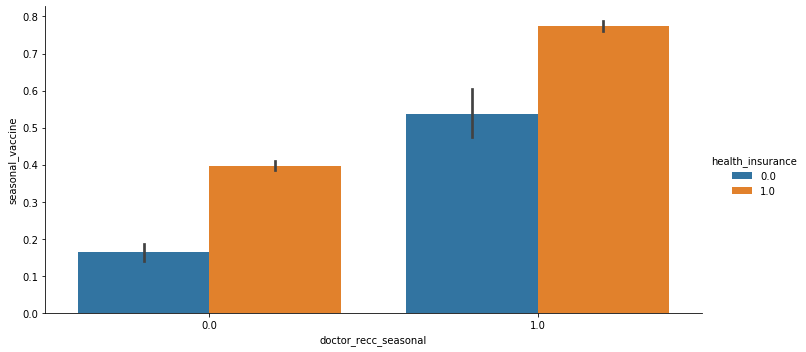

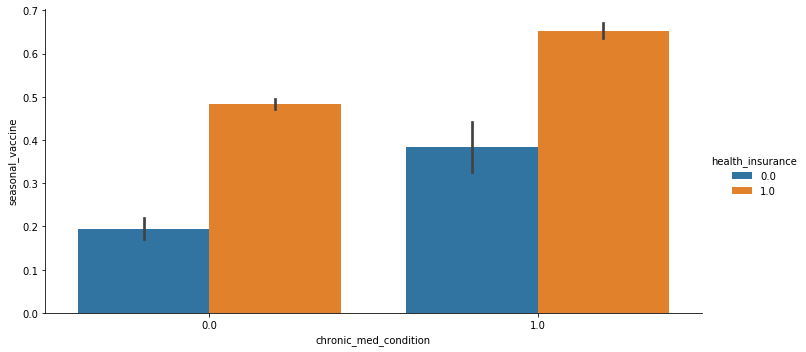

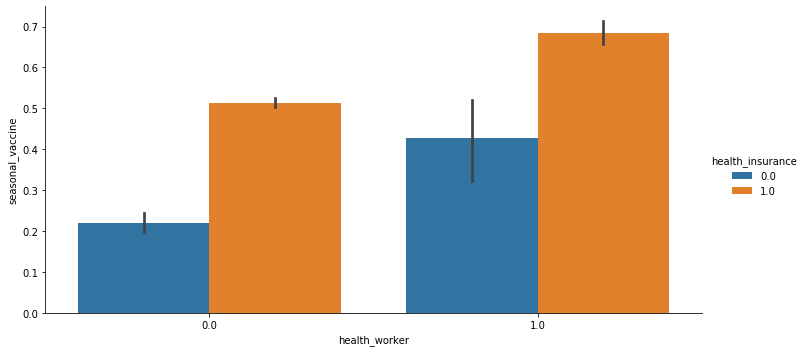

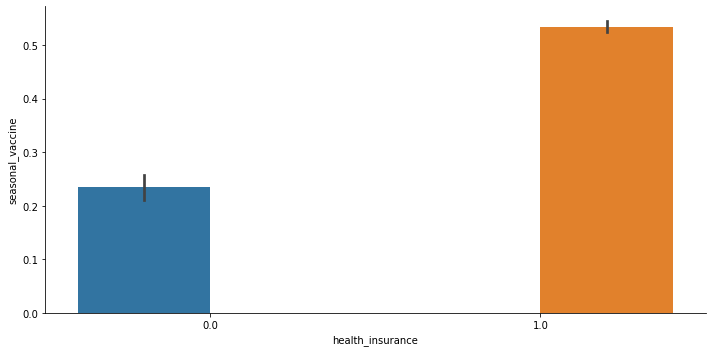

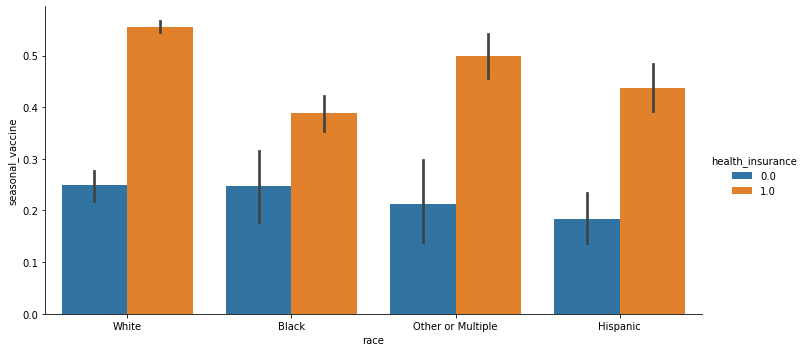

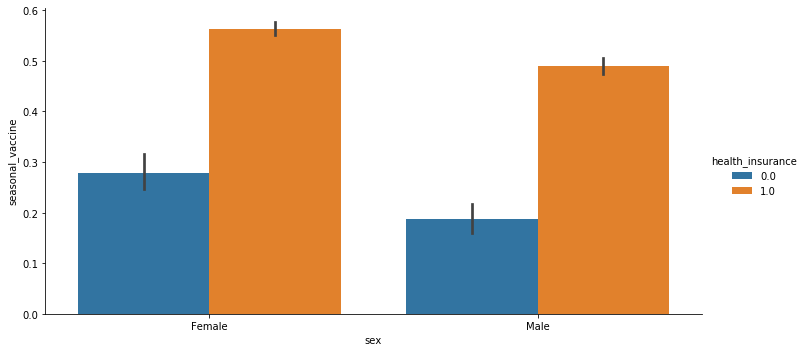

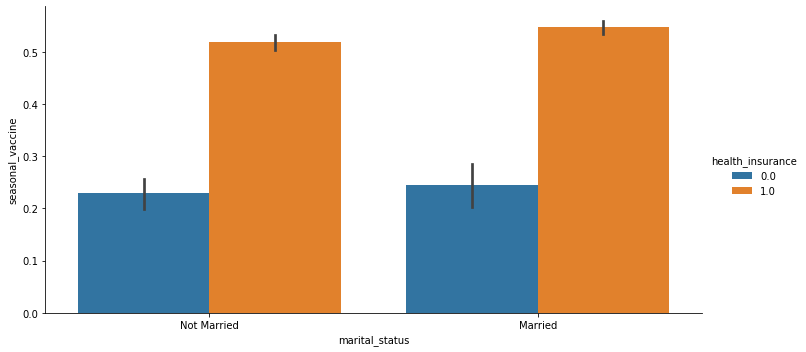

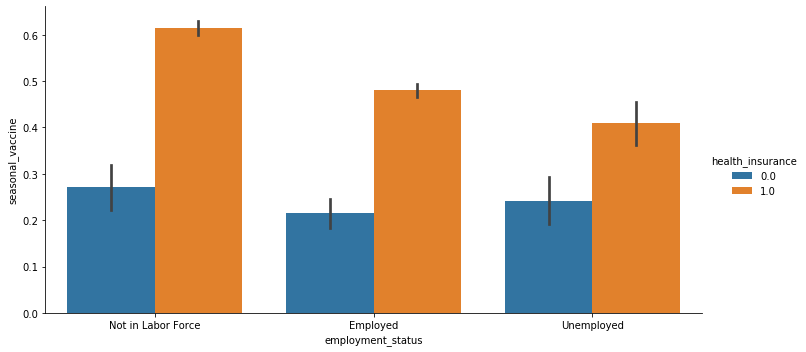

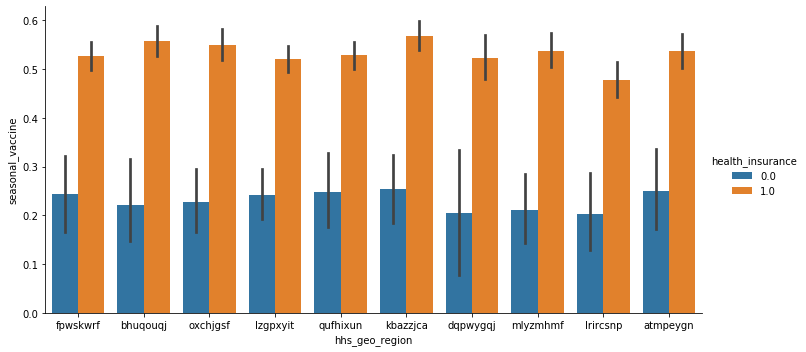

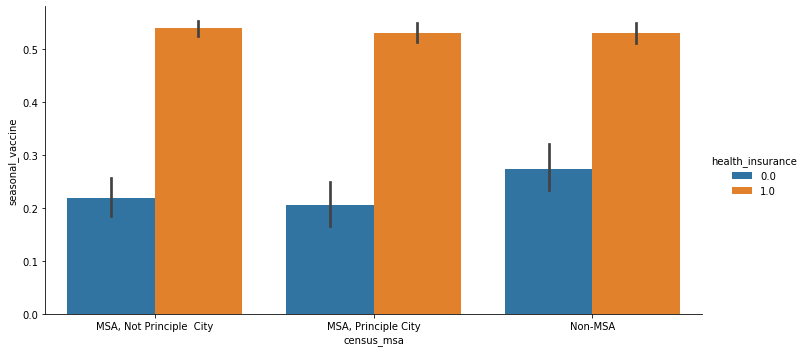

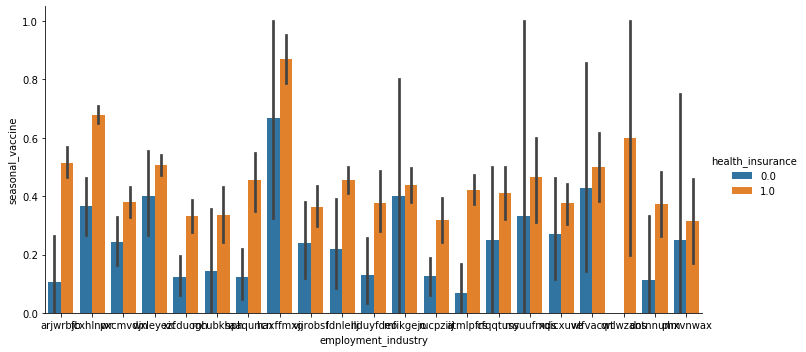

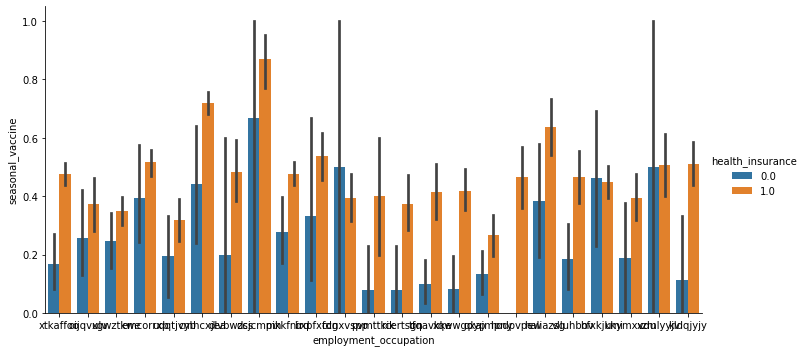

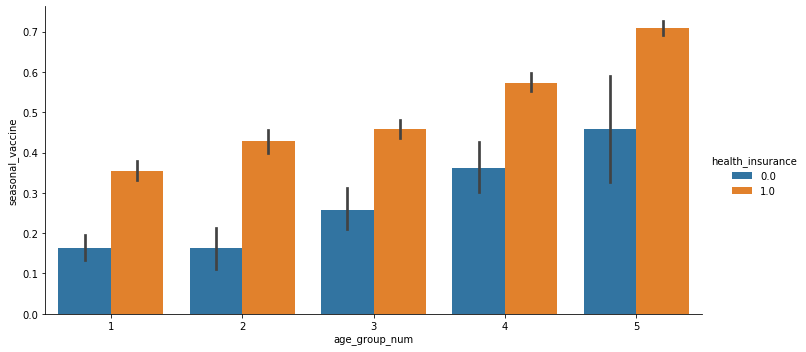

In [19]:
# plot bar graphs for each variable vs target
# test different hues to get sense of variable interactions

for c in train_to_plot.drop(columns=['seasonal_vaccine']).columns:
    sns.catplot(x=c, y="seasonal_vaccine", kind="bar", hue='health_insurance', data=train_to_plot, height=5, aspect=2)
    
# interesting interactions:
# sex and marital status
# census_msa and race (what's going on?)
# sex and race
# also sex and employment status --> probably due to age

### Baseline Model

Please see the [baseline model notebook](https://github.com/lilisbeit/vaccine-learning/blob/main/baseline-model.ipynb) to view the initial logistic regression model I tested.  This model encoded all categorical columns while dropping the first category in each, creating a dataframe of only binary columns.  I then filled all null values with 0.5.  This baseline model produced an **ROC-AUC score of 0.76** on both the training and test sets.

### Model Evaluation

I used an ROC-AUC score, accuracy score, and F1 score to evaluate model performance throughout this project. The model's purpose is to obtain a rough estimate of which patients are less likely to receive the flu vaccine and target them for outreach. There is no need to identify every single patient who did or did not get the vaccine, so these composite scores are better measures than precision or recall.  Accuracy and F1 mostly moved in lockstep with ROC-AUC, and provided equally good measures of performance.

### Feature Engineering

In this section, I tested different ways to engineer the variables to improve model performance.

I grouped together categories in the 'employment_industry' and 'employment_occupation' columns that had similar vaccination outcomes to reduce dimensionality.

I also experimented with dropping all firsts, some firsts, and no firsts when encoding.  Dropping just two firsts slightly improved model performance.

Finally, I filled all null values with 0 and created additional columns to mark whether the original information was null.  This method produced slightly better scores than imputing 0.5 for all nulls.

These three changes improved model performance, producing an **ROC-AUC score of 0.78** for the test and train sets.

I also tested using scalers, adding interaction terms, and changing the parameters of the logistic regression.  None of these changes improved model performance.


**Reduce Number of Columns by Grouping Similar Categories**

['haxffmxo' 'fcxhlnwr' 'qnlwzans' 'arjwrbjb' 'wxleyezf' 'msuufmds'
 'mfikgejo' 'wlfvacwt' 'ldnlellj' 'atmlpfrs' 'cfqqtusy' 'dotnnunm'
 'pxcmvdjn' 'phxvnwax' 'xqicxuve' 'vjjrobsf' 'saaquncn' 'nduyfdeo'
 'mcubkhph' 'xicduogh' 'rucpziij']


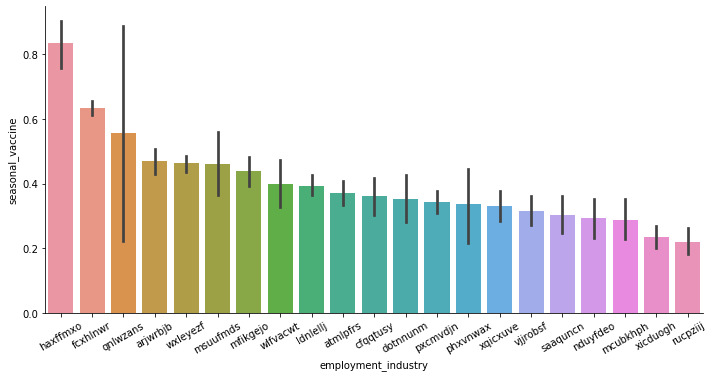

In [20]:
# arrange employment_industry values by probability - see if there are groupings
# reducing number of columns may reduce overfitting and improve the model

sort_order = train_to_plot.groupby('employment_industry')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_industry', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [21]:
# create employment_industry groupings

ind_cat_1 = ['haxffmxo'] # clearly number one
ind_cat_2 = ['fcxhlnwr'] # clearly number two
ind_cat_3 = ['qnlwzans'] # clearly an oddball
ind_cat_4 = ['rucpziij','xicduogh'] # on the bottom
ind_cat_5 = ['msuufmds','arjwrbjb','wxleyezf','mfikgejo','wlfvacwt','phxvnwax','ldnlellj','dotnnunm','atmlpfrs'] # mid upper
ind_cat_6 = ['cfqqtusy','pxcmvdjn','xqicxuve','vjjrobsf','nduyfdeo','mcubkhph','saaquncn'] # mid lower

In [22]:
# create columns for employment_industry categories

ind_cat_list = [ind_cat_1, ind_cat_2, ind_cat_3, ind_cat_4, ind_cat_5, ind_cat_6]

for n, ind_cat in enumerate(ind_cat_list):
    X_train['ind_cat_'+str(n+1)] = X_train['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6
15266,1.00000,1.00000,0.00000,1.00000,65+ Years,White,Female,Not Married,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0
17217,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Married,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0
19265,0.00000,1.00000,0.00000,1.00000,35 - 44 Years,White,Female,Married,Employed,oxchjgsf,"MSA, Principle City",arjwrbjb,xtkaffoo,0,0,0,0,1,0
23773,0.00000,0.00000,0.00000,1.00000,45 - 54 Years,White,Female,Married,Not in Labor Force,lzgpxyit,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
18359,1.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Female,Married,Employed,bhuqouqj,Non-MSA,fcxhlnwr,oijqvulv,0,1,0,0,0,0
12359,1.00000,1.00000,0.00000,1.00000,35 - 44 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",pxcmvdjn,xgwztkwe,0,0,0,0,0,1
15654,1.00000,1.00000,0.00000,1.00000,65+ Years,White,Male,Married,Not in Labor Force,kbazzjca,Non-MSA,NaN,NaN,0,0,0,0,0,0
24287,0.00000,0.00000,0.00000,1.00000,18 - 34 Years,White,Female,Married,Employed,bhuqouqj,"MSA, Not Principle City",wxleyezf,emcorrxb,0,0,0,0,1,0
18626,1.00000,0.00000,0.00000,nan,65+ Years,Black,Female,Married,Not in Labor Force,kbazzjca,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0
18847,nan,0.00000,0.00000,nan,55 - 64 Years,White,Male,Not Married,Employed,oxchjgsf,"MSA, Principle City",xicduogh,uqqtjvyb,0,0,0,1,0,0


['dcjcmpih' 'cmhcxjea' 'haliazsg' 'emcorrxb' 'xzmlyyjv' 'bxpfxfdn'
 'hodpvpew' 'dlvbwzss' 'mxkfnird' 'hfxkjkmi' 'kldqjyjy' 'xtkaffoo'
 'ccgxvspp' 'vlluhbov' 'oijqvulv' 'ukymxvdu' 'xgwztkwe' 'xqwwgdyp'
 'rcertsgn' 'pvmttkik' 'tfqavkke' 'uqqtjvyb' 'qxajmpny']


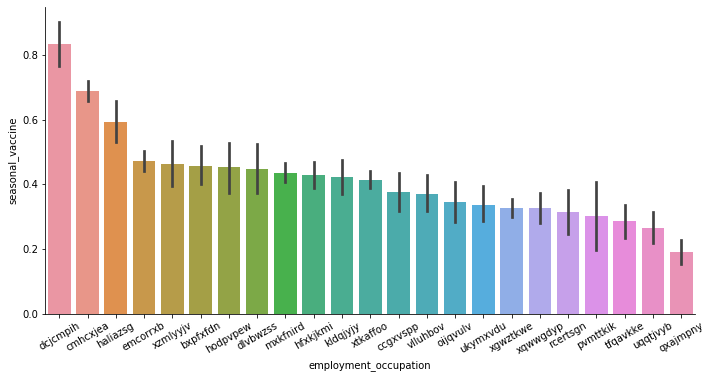

In [23]:
# arrange employment_occupation values by probability - see if there are groupings

sort_order = train_to_plot.groupby('employment_occupation')['seasonal_vaccine'].mean().sort_values(ascending=False).index.values
plot = sns.catplot(data=train_to_plot, x='employment_occupation', y='seasonal_vaccine', kind='bar', height=5, aspect=2, order=sort_order)
plot.set_xticklabels(rotation=30)
print(sort_order)

In [24]:
# create employment_occupation categories

occ_cat_1 = ['dcjcmpih'] # clearly number one
occ_cat_2 = ['cmhcxjea'] # clearly number two
occ_cat_3 = ['haliazsg'] # clearly number three
occ_cat_4 = ['tfqavkke','uqqtjvyb','qxajmpny'] # on the bottom
occ_cat_5 = ['xzmlyyjv', 'hodpvpew', 'emcorrxb','bxpfxfdn', 'mxkfnird', 'xtkaffoo', 'hfxkjkmi', 'dlvbwzss', 'kldqjyjy'] # mid upper
occ_cat_6 = ['vlluhbov','ukymxvdu','oijqvulv','xgwztkwe','rcertsgn','ccgxvspp','pvmttkik', 'xqwwgdyp'] # mid lower

In [25]:
# create categories for employment_occupation to reduce dimensionality

occ_cat_list = [occ_cat_1, occ_cat_2, occ_cat_3, occ_cat_4, occ_cat_5, occ_cat_6]

for n, occ_cat in enumerate(occ_cat_list):
    X_train['occ_cat_'+str(n+1)] = X_train['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)
    
X_train.head(100)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,age_group,race,sex,marital_status,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6
15266,1.00000,1.00000,0.00000,1.00000,65+ Years,White,Female,Not Married,Not in Labor Force,fpwskwrf,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
17217,1.00000,1.00000,0.00000,nan,65+ Years,White,Female,Married,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
19265,0.00000,1.00000,0.00000,1.00000,35 - 44 Years,White,Female,Married,Employed,oxchjgsf,"MSA, Principle City",arjwrbjb,xtkaffoo,0,0,0,0,1,0,0,0,0,0,1,0
23773,0.00000,0.00000,0.00000,1.00000,45 - 54 Years,White,Female,Married,Not in Labor Force,lzgpxyit,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
18359,1.00000,0.00000,0.00000,1.00000,35 - 44 Years,White,Female,Married,Employed,bhuqouqj,Non-MSA,fcxhlnwr,oijqvulv,0,1,0,0,0,0,0,0,0,0,0,1
12359,1.00000,1.00000,0.00000,1.00000,35 - 44 Years,White,Female,Married,Employed,qufhixun,"MSA, Not Principle City",pxcmvdjn,xgwztkwe,0,0,0,0,0,1,0,0,0,0,0,1
15654,1.00000,1.00000,0.00000,1.00000,65+ Years,White,Male,Married,Not in Labor Force,kbazzjca,Non-MSA,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
24287,0.00000,0.00000,0.00000,1.00000,18 - 34 Years,White,Female,Married,Employed,bhuqouqj,"MSA, Not Principle City",wxleyezf,emcorrxb,0,0,0,0,1,0,0,0,0,0,1,0
18626,1.00000,0.00000,0.00000,nan,65+ Years,Black,Female,Married,Not in Labor Force,kbazzjca,"MSA, Principle City",NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
18847,nan,0.00000,0.00000,nan,55 - 64 Years,White,Male,Not Married,Employed,oxchjgsf,"MSA, Principle City",xicduogh,uqqtjvyb,0,0,0,1,0,0,0,0,0,1,0,0


In [26]:
# drop old 'employment_industry' and 'employment_occupation' columns

X_train.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Test dropping different first categories when encoding**

In [27]:
# encode remaining categorical columns in X_train
# do not drop all firsts, but drop sex_Female and race_Other to reduce columns

X_train_enc = pd.get_dummies(X_train, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# experimented with dropping all firsts as in baseline model, but produced worse scores

# scores when dropped 1 column - female
# ROC Scores
# Train: 0.7817244813917411
# Test: 0.7748843069535213

# scores when dropped 2 columns - female and other race
# ROC Scores
# Train: 0.7803958619891809
# Test: 0.7782699504901386

# scores when 5 columns dropped
# ROC Scores
# Train: 0.780485435457886
# Test: 0.772152694994743

# stick with dropping 2 columns - female and other race

In [28]:
# 4 binary columns still have nulls
X_train_enc.isna().sum()[:4]

doctor_recc_seasonal     1631
chronic_med_condition     744
health_worker             627
health_insurance         9224
dtype: int64

**Explore the Possibility of Deleting Rows with Nulls**

Conclusion: There are too many null values to delete all rows with nulls, even in any one category.

In [29]:
# calculate what per cent of rows would be deleted if we deleted rows with nulls

# cannot delete rows with missing health_insurance, since about 50%
# check for overlaps in nulls in other 3 rows, may be possible to delete these rows

X_train_delete_nulls = X_train.loc[(X_train['doctor_recc_seasonal'].notnull()
                                      & X_train['chronic_med_condition'].notnull()
                                      & X_train['health_worker'].notnull())]
X_train_delete_nulls

print('If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:')
print('Number of rows deleted:', len(X_train) - len(X_train_delete_nulls))
print('Per cent of rows deleted:', round(((len(X_train) - len(X_train_delete_nulls))/len(X_train)*100),2), '%')

# if we delete all nulls in all 3 columns, we lose 2295 rows, 11% of data
# so let's not delete them
# Instead, fill them with 0s and create columns to indicate if they had nulls
# also tested filling them with the dummy value 0.5, but did not improve model

If I deleted rows with nulls in doctor_recc_seasonal, chronic_med_condition, health_worker:
Number of rows deleted: 2274
Per cent of rows deleted: 11.35 %


**Create new columns to capture null info, and fill nulls with 0**

This method improves perforance slightly over filling all nulls with a dummy value, as in the baseline model.


In [30]:
# create new columns to capture null info prior to filling nans with 0

X_train_nans=X_train_enc.copy()
X_train_nans['null_doctor_recc'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_chronic'] = X_train_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_worker'] = X_train_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans['null_health_ins'] = X_train_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)
X_train_nans.head(100)

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
15266,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
17217,1.00000,1.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
19265,0.00000,1.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
23773,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
18359,1.00000,0.00000,0.00000,1.00000,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12359,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
15654,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
24287,0.00000,0.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
18626,1.00000,0.00000,0.00000,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
18847,nan,0.00000,0.00000,nan,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1


In [31]:
# fill nans with 0

X_train_nans.fillna(value=0, inplace=True)
X_train_nans.isna().sum().sum() #0
X_train_nans.shape
X_train_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
15266,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
17217,1.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
19265,0.00000,1.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
23773,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
18359,1.00000,0.00000,0.00000,1.00000,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
5863,0.00000,0.00000,1.00000,0.00000,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
24702,0.00000,1.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1
8860,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


**Create correlation matrix to check for multicolinearity**

No surprising correlations, except maybe ind_cat_1 and occ_cat_1.  Looks like these are exactly the same people.  Also, the same rows have null info for doctor_recc_seasonal and chronic_med_condition.  In next pass, experiment with deleting 1 of each pair.

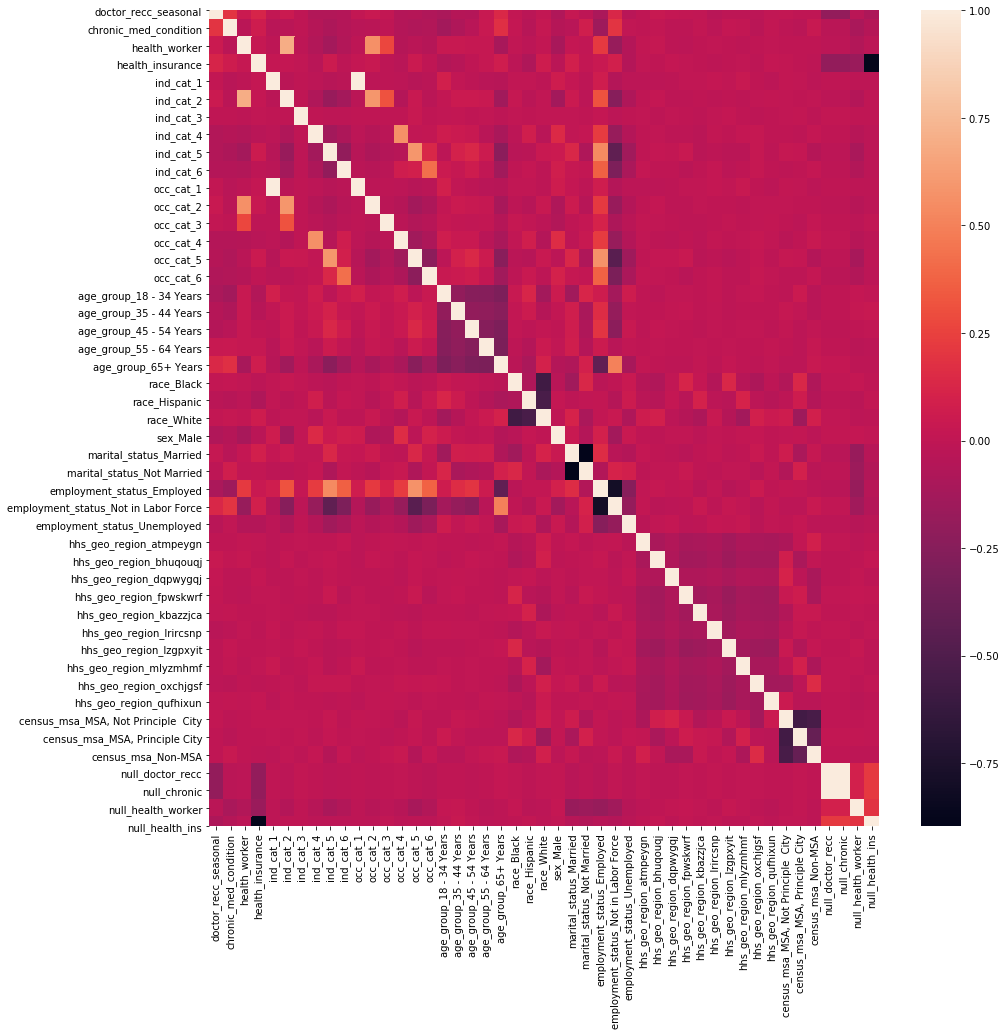

In [32]:
corr = X_train_nans.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, ax=ax);

**Run test set through feature engineering changes and evaluate model**

New **ROC-AUC score is 0.78** for training and test sets.

In [33]:
# run X_test thru same steps

# create categories for employment_industry
for n, ind_cat in enumerate(ind_cat_list):
    X_test['ind_cat_'+str(n+1)] = X_test['employment_industry'].map(lambda x: 1 if x in ind_cat else 0)

# create categories for employment_industry
for n, occ_cat in enumerate(occ_cat_list):
    X_test['occ_cat_'+str(n+1)] = X_test['employment_occupation'].map(lambda x: 1 if x in occ_cat else 0)

X_test.drop(columns=['employment_industry','employment_occupation'], inplace=True)

# encode categorical columns
X_test_enc = pd.get_dummies(X_test, drop_first=False).drop(columns=['sex_Female','race_Other or Multiple'])

# create columns to track null values
X_test_nans=X_test_enc.copy()
X_test_nans['null_doctor_recc'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_chronic'] = X_test_nans['doctor_recc_seasonal'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_worker'] = X_test_nans['health_worker'].apply(lambda x:1 if pd.isnull(x) else 0)
X_test_nans['null_health_ins'] = X_test_nans['health_insurance'].apply(lambda x:1 if pd.isnull(x) else 0)

# fill remaining nulls with 0
X_test_nans.fillna(value=0, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pan

In [34]:
X_test_nans

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins
21433,1.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
7218,0.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4130,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2928,0.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
11722,1.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11551,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
11553,0.00000,0.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
14523,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
6964,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


ROC Scores
Train: 0.7761393321295921
Test: 0.7879239532338177


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7188857271229594


F1 Scores
Train: 0.6753188882080989
Test: 0.6862777870633462


Cross-Validation Scores:
Train:
[0.77198527 0.78044359 0.77648658 0.77616371 0.76321877]
Mean: 0.774
Test:
[0.790126   0.78421603 0.79461822 0.79276322 0.76898734]
Mean: 0.786


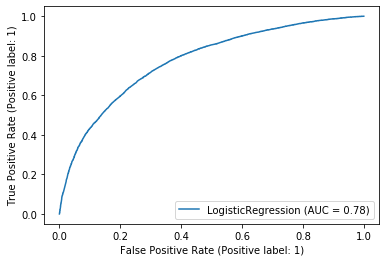

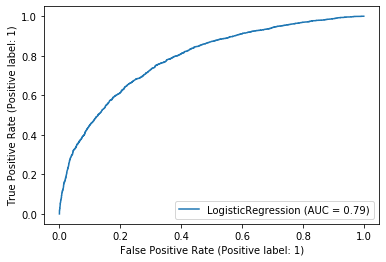

In [35]:
# plot ROC curves
logreg = ut.logreg_predict_score(X_train_nans, X_test_nans, y_train, y_test)
plot_roc_curve(logreg, X_train_nans, y_train)
plot_roc_curve(logreg, X_test_nans, y_test)


**Test Standard Scaler**

In [36]:
# Let's scale it!  # test Standard Scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

In [37]:
ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale
# only F1 scores are better for standard scaler.  Why?  Test on next pass

ROC Scores
Train: 0.7761540101905219
Test: 0.7882415701321538


Accuracy Scores
Train: 0.7093859211183225
Test: 0.7131945484499026


F1 Scores
Train: 0.6898939854030153
Test: 0.6952092949228075


Cross-Validation Scores:
Train:
[0.77229989 0.78037145 0.77642621 0.77615319 0.76333023]
Mean: 0.774
Test:
[0.79066169 0.78346667 0.79462048 0.79298861 0.76935248]
Mean: 0.786


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

**Test MinMax Scaler**

In [38]:
# Let's scale it!  # test MixMax Scaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_nans)
X_test_scaled = scaler.transform(X_test_nans)

ut.logreg_predict_score(X_train_scaled, X_test_scaled, y_train, y_test)

# no change - makes sense since everything is already on a 0-1 scale

ROC Scores
Train: 0.7761393321295921
Test: 0.7879239532338177


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7188857271229594


F1 Scores
Train: 0.6753188882080989
Test: 0.6862777870633462


Cross-Validation Scores:
Train:
[0.77198527 0.78044359 0.77648658 0.77616371 0.76321877]
Mean: 0.774
Test:
[0.790126   0.78421603 0.79461822 0.79276322 0.76898734]
Mean: 0.786


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

**Test Interaction Term for 'male' and 'married'**

In [39]:
# add interaction term for man & married

X_train_inter = X_train_nans.copy()
X_train_inter['man_Married'] = X_train_inter['sex_Male'] * X_train_inter['marital_status_Married']
X_train_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
15266,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
17217,1.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
19265,0.00000,1.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
23773,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
18359,1.00000,0.00000,0.00000,1.00000,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1
5863,0.00000,0.00000,1.00000,0.00000,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
24702,0.00000,1.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,1
8860,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [40]:
# do same steps on X_test
X_test_inter = X_test_nans.copy()
X_test_inter['man_Married'] = X_test_inter['sex_Male'] * X_test_inter['marital_status_Married']
X_test_inter

,doctor_recc_seasonal,chronic_med_condition,health_worker,health_insurance,ind_cat_1,ind_cat_2,ind_cat_3,ind_cat_4,ind_cat_5,ind_cat_6,occ_cat_1,occ_cat_2,occ_cat_3,occ_cat_4,occ_cat_5,occ_cat_6,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_White,sex_Male,marital_status_Married,marital_status_Not Married,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,null_doctor_recc,null_chronic,null_health_worker,null_health_ins,man_Married
21433,1.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
7218,0.00000,1.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4130,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2928,0.00000,1.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
11722,1.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11551,1.00000,0.00000,0.00000,1.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
11553,0.00000,0.00000,0.00000,1.00000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
14523,1.00000,1.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
6964,0.00000,0.00000,0.00000,1.00000,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [41]:
# test version with interaction term

ut.logreg_predict_score(X_train_inter, X_test_inter, y_train, y_test)

# no change

ROC Scores
Train: 0.7761694096305553
Test: 0.7877379784031322


Accuracy Scores
Train: 0.7094857713429855
Test: 0.7182866556836903


F1 Scores
Train: 0.6759841862019043
Test: 0.686029043565348


Cross-Validation Scores:
Train:
[0.77218491 0.78022642 0.77639565 0.77632577 0.76314864]
Mean: 0.774
Test:
[0.79033982 0.78383797 0.79471514 0.79275646 0.76880928]
Mean: 0.786


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

**Test LogisticRegression() parameters**

ROC Scores
Train: 0.7761393221104379
Test: 0.7879262959400181


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7188857271229594


F1 Scores
Train: 0.6753188882080989
Test: 0.6862777870633462


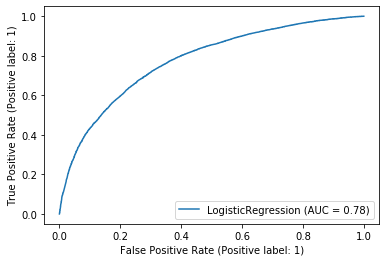

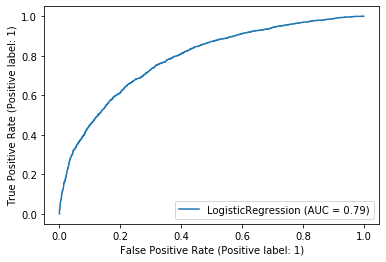

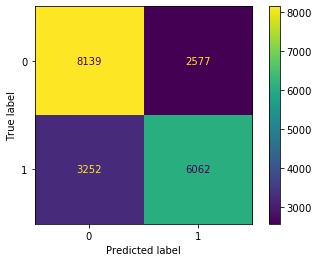

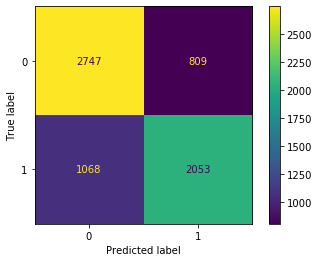

In [42]:
# test fit_intercept=True

# make logistic regression
logreg = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear')
logreg.fit(X_train_nans, y_train)

# print ROC scores
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)

# no change

LogisticRegression(C=10, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7761359456554663
Test: 0.7879217006317016


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7187359592631422


F1 Scores
Train: 0.6753188882080989
Test: 0.6861631016042782


LogisticRegression(C=100, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.776138550635563
Test: 0.7879262959400181


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7188857271229594


F1 Scores
Train: 0.6753188882080989
Test: 0.6862777870633462


LogisticRegression(C=1000, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7761394122828258
Test: 0.78792458396241


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7188857271229594


F1 Scores
Train: 0.6753188882080989
Test: 0.6862777870633462




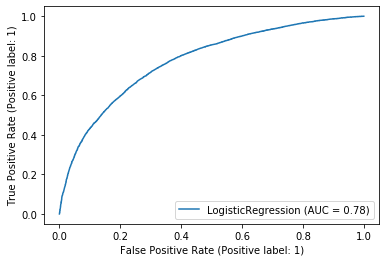

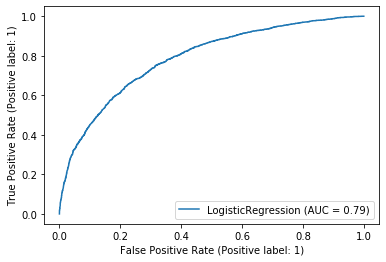

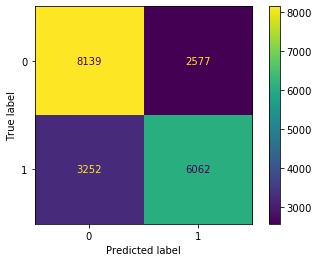

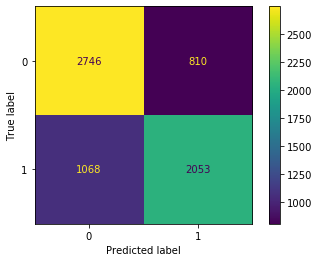

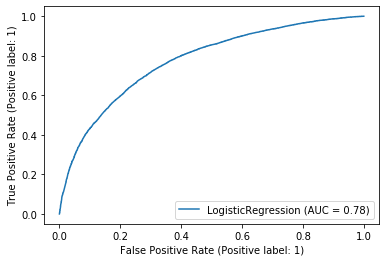

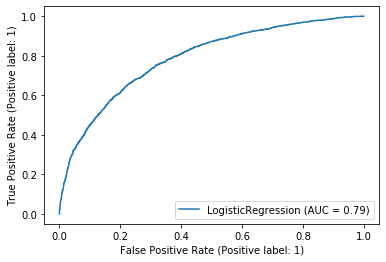

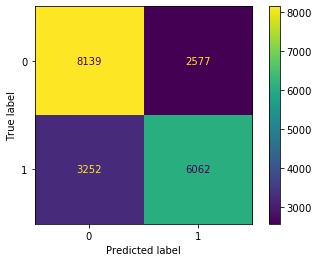

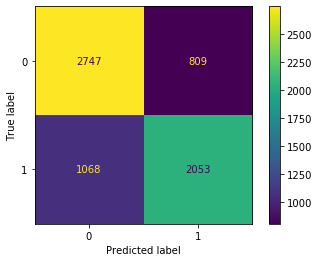

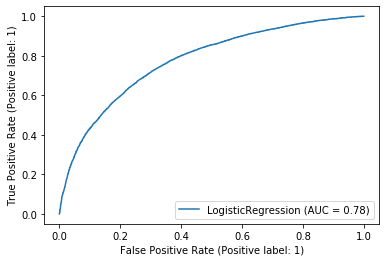

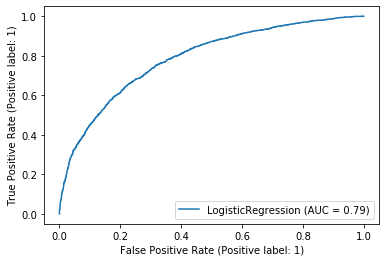

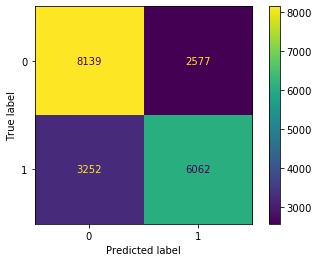

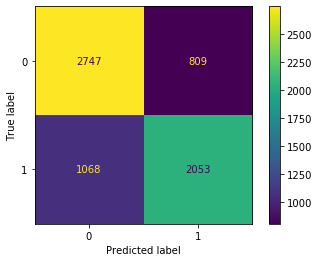

In [43]:
# test C

c_list = [10,100,1000]

# make logreg and score
for c in c_list:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    logreg.fit(X_train_nans, y_train)
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
# no change

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='newton-cg')
ROC Scores
Train: 0.7761391016890451
Test: 0.787924854274664


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7188857271229594


F1 Scores
Train: 0.6753188882080989
Test: 0.6862777870633462




/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

LogisticRegression(C=1000000000000.0, fit_intercept=False)
ROC Scores
Train: 0.7761354046211385
Test: 0.7879602651799251


Accuracy Scores
Train: 0.709136295556665
Test: 0.7187359592631422


F1 Scores
Train: 0.6754317548746518
Test: 0.6861631016042782


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')
ROC Scores
Train: 0.7761393321295921
Test: 0.7879239532338177


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7188857271229594


F1 Scores
Train: 0.6753188882080989
Test: 0.6862777870633462


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='sag')
ROC Scores
Train: 0.7761394924360595
Test: 0.7879231422970558


Accuracy Scores
Train: 0.7089865202196705
Test: 0.7187359592631422


F1 Scores
Train: 0.6753188882080989
Test: 0.6861631016042782


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='saga')
ROC Scores
Train: 0.7761391618039704
Test: 0.7879244037542409


Accuracy Scores
Train: 0.7089865202196705
Test: 0.71888572712295

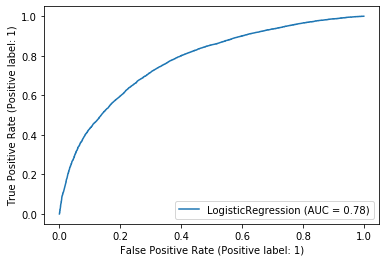

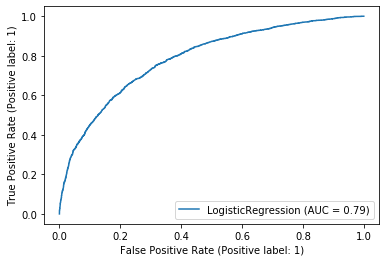

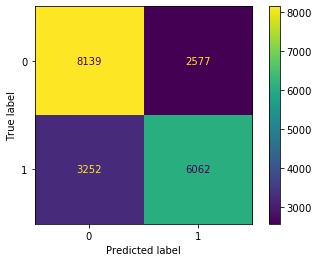

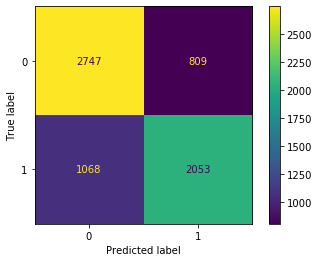

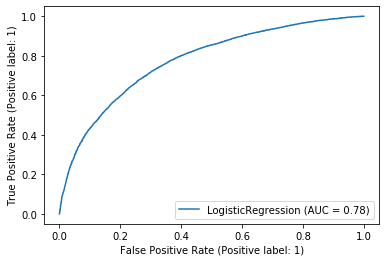

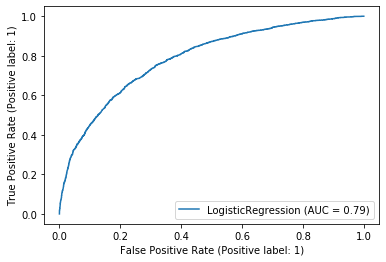

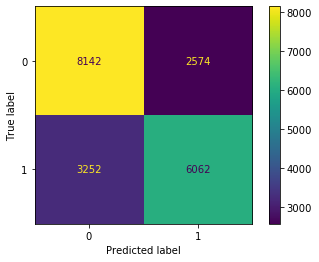

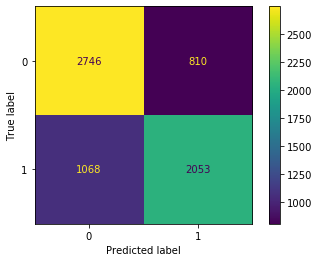

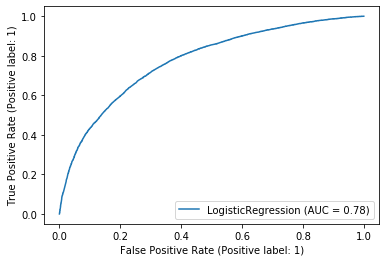

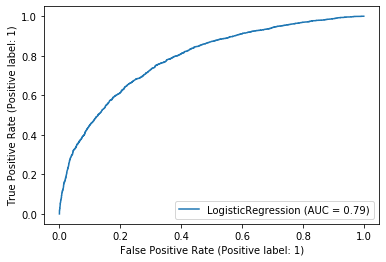

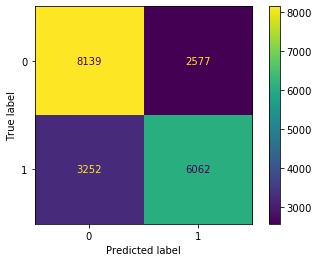

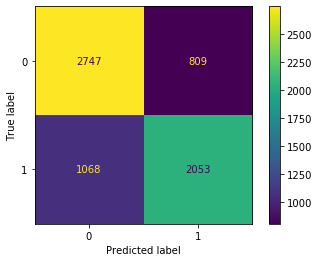

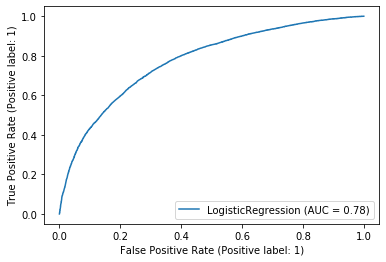

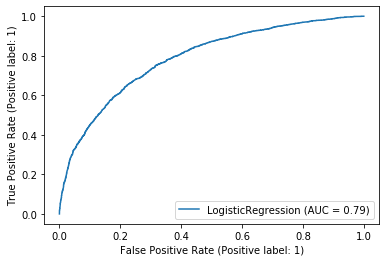

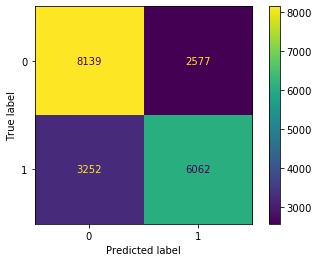

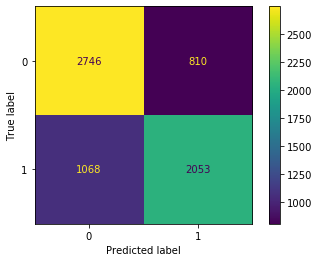

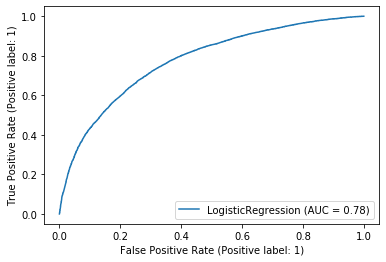

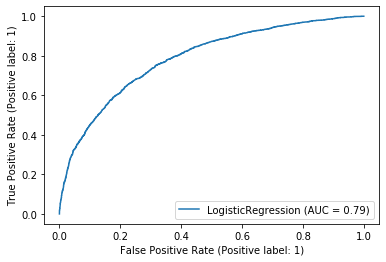

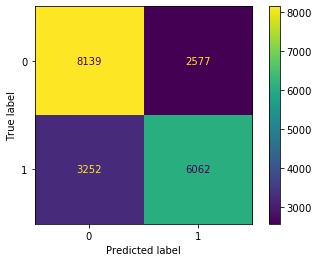

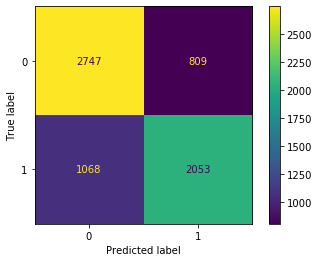

In [44]:
# test solvers

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for s in solvers:
    # make logistic regression
    logreg = LogisticRegression(fit_intercept=False, C=1e12, solver=s)
    logreg.fit(X_train_nans, y_train)
    # score
    print(logreg)
    ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, logreg)
    print('\n')
    
    # no change

In [45]:
# no change when using different scalers, adding interaction terms, or changing logreg parameters
# stick with inital df (X_train_nans)
# stick with initial parameters for logreg

best_logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
best_logreg.fit(X_train_nans, y_train)


LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

### Check Coefficient Weights

In [46]:
# check out coefficients

top_ten = ut.order_features(best_logreg.coef_[0], X_train_nans)[:10]
top_ten

,weight,abs_weight
doctor_recc_seasonal,1.45450,1.45450
ind_cat_1,1.44530,1.44530
occ_cat_1,1.44530,1.44530
ind_cat_3,1.05670,1.05670
age_group_18 - 34 Years,-0.95370,0.95370
census_msa_Non-MSA,-0.68710,0.68710
age_group_35 - 44 Years,-0.66600,0.66600
health_worker,0.63500,0.63500
health_insurance,0.59550,0.59550
ind_cat_2,0.59430,0.59430


In [47]:
# run lists below to be sure my coefficients are linking up to the right column labels
# they are

tuple_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, best_logreg.coef_[0][n])
    tuple_list.append(tuple)
    
tuple_list

[(0, 1.4544506121144352),
 (1, 0.33899615706692876),
 (2, 0.6349940531827527),
 (3, 0.5955066083283582),
 (4, 1.4452866366902195),
 (5, 0.5943474443299761),
 (6, 1.0567112755501773),
 (7, -0.10143493298090248),
 (8, 0.39529267571278953),
 (9, 0.054391037075096516),
 (10, 1.4452866366902195),
 (11, 0.42184500117259277),
 (12, 0.12201172569509637),
 (13, -0.2411414477810988),
 (14, 0.10866304740220155),
 (15, -0.11425231198542404),
 (16, -0.9536772228191425),
 (17, -0.6660071706357991),
 (18, -0.48402243018827595),
 (19, -0.1536680480457807),
 (20, 0.5215389882170794),
 (21, -0.5533398514847041),
 (22, -0.0918897569391822),
 (23, 0.0749002552132113),
 (24, -0.09682388312588493),
 (25, -0.08268554404419431),
 (26, -0.28062451472886013),
 (27, -0.31532444412980065),
 (28, 0.04308039120336115),
 (29, -0.268001626147624),
 (30, -0.0645997310138206),
 (31, -0.16292023241531078),
 (32, -0.328338376146157),
 (33, -0.09528157418246626),
 (34, -0.08069985111138771),
 (35, -0.32413497454714024),
 

In [48]:
col_list = []

for n in range(len(best_logreg.coef_[0])):
    tuple = (n, X_train_nans.columns[n])
    col_list.append(tuple)
    
col_list

[(0, 'doctor_recc_seasonal'),
 (1, 'chronic_med_condition'),
 (2, 'health_worker'),
 (3, 'health_insurance'),
 (4, 'ind_cat_1'),
 (5, 'ind_cat_2'),
 (6, 'ind_cat_3'),
 (7, 'ind_cat_4'),
 (8, 'ind_cat_5'),
 (9, 'ind_cat_6'),
 (10, 'occ_cat_1'),
 (11, 'occ_cat_2'),
 (12, 'occ_cat_3'),
 (13, 'occ_cat_4'),
 (14, 'occ_cat_5'),
 (15, 'occ_cat_6'),
 (16, 'age_group_18 - 34 Years'),
 (17, 'age_group_35 - 44 Years'),
 (18, 'age_group_45 - 54 Years'),
 (19, 'age_group_55 - 64 Years'),
 (20, 'age_group_65+ Years'),
 (21, 'race_Black'),
 (22, 'race_Hispanic'),
 (23, 'race_White'),
 (24, 'sex_Male'),
 (25, 'marital_status_Married'),
 (26, 'marital_status_Not Married'),
 (27, 'employment_status_Employed'),
 (28, 'employment_status_Not in Labor Force'),
 (29, 'employment_status_Unemployed'),
 (30, 'hhs_geo_region_atmpeygn'),
 (31, 'hhs_geo_region_bhuqouqj'),
 (32, 'hhs_geo_region_dqpwygqj'),
 (33, 'hhs_geo_region_fpwskwrf'),
 (34, 'hhs_geo_region_kbazzjca'),
 (35, 'hhs_geo_region_lrircsnp'),
 (36, 'h

In [49]:
# run permutation importance to confirm feature importance

r = permutation_importance(best_logreg, X_test_nans, y_test, n_repeats=30)

In [50]:
top_ten = ut.order_features(r['importances'][:,0], X_train_nans)[:10]
top_ten

,weight,abs_weight
doctor_recc_seasonal,0.08750,0.08750
"census_msa_MSA, Principle City",0.01450,0.01450
census_msa_Non-MSA,0.01320,0.01320
age_group_65+ Years,0.01290,0.01290
age_group_35 - 44 Years,0.01020,0.01020
age_group_18 - 34 Years,0.01000,0.01000
chronic_med_condition,0.00760,0.00760
"census_msa_MSA, Not Principle City",0.00760,0.00760
health_insurance,0.00660,0.00660
ind_cat_2,0.00630,0.00630


### Create plots for presentation to showcase influential variables

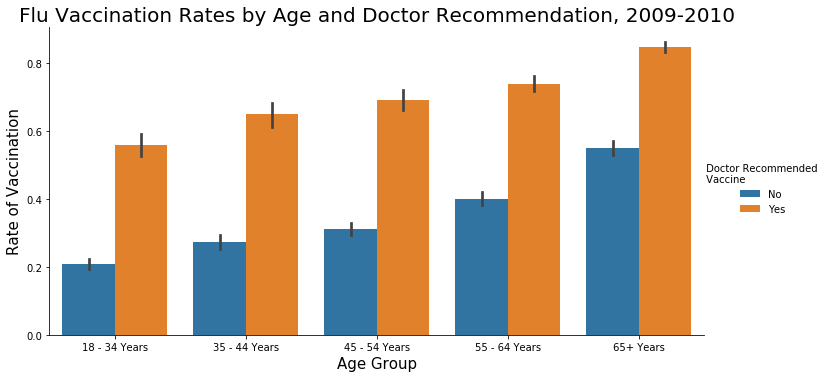

In [51]:
# create a plot to show importance of doctor recommendation

# create new df for plotting age
age_plot = pd.concat([X_train, y_train], axis=1)

# sort age categories appropriately for plotting
sort_order = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']

ax = sns.catplot(data=age_plot, x='age_group', y='seasonal_vaccine', hue='doctor_recc_seasonal', kind='bar', height=5, aspect=2, order=sort_order)
plt.title('Flu Vaccination Rates by Age and Doctor Recommendation, 2009-2010', fontsize=20)
plt.xlabel('Age Group', fontsize=15)
plt.ylabel('Rate of Vaccination', fontsize=15)
# title
new_title = ' Doctor Recommended \n Vaccine'
ax._legend.set_title(new_title)
# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l);
plt.savefig('images/doc_rec.png')

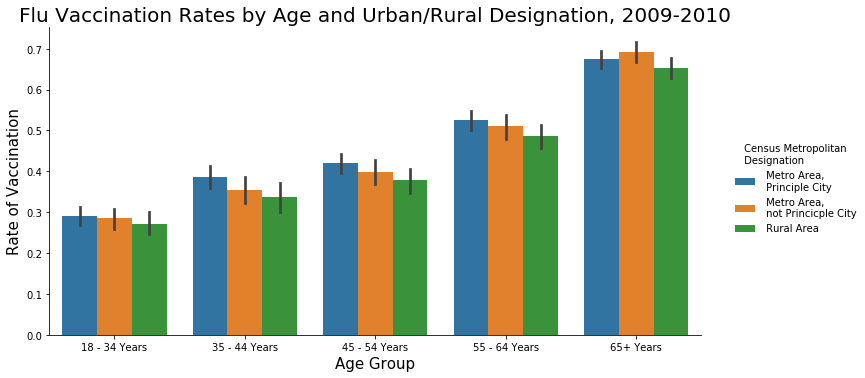

In [52]:
# create a plot to show importance of urban/rural designation

# sort age categories appropriately for plotting
sort_order = ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years']

ax = sns.catplot(data=age_plot, x='age_group', y='seasonal_vaccine', hue='census_msa', kind='bar', height=5, aspect=2, order=sort_order)
plt.title('Flu Vaccination Rates by Age and Urban/Rural Designation, 2009-2010', fontsize=20)
plt.xlabel('Age Group', fontsize=15)
plt.ylabel('Rate of Vaccination', fontsize=15)
# title
new_title = ' Census Metropolitan \n Designation'
ax._legend.set_title(new_title)
# replace labels
new_labels = [' Metro Area, \n Principle City', ' Metro Area, \n not Princicple City', ' Rural Area']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l);
plt.savefig('images/msa.png')


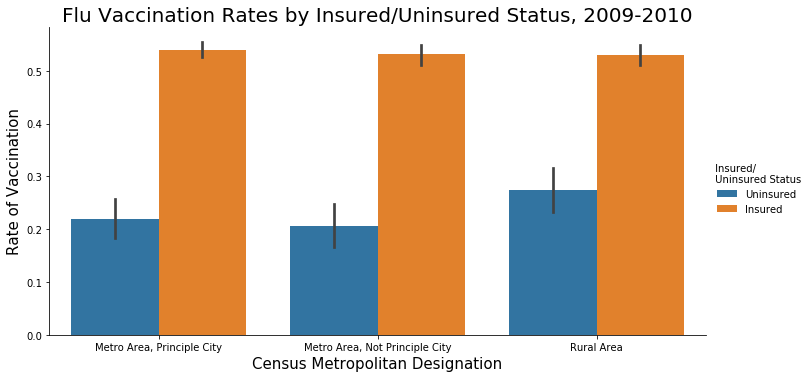

In [53]:
# create a plot to show importance of health insurance

ax = sns.catplot(data=age_plot, x='census_msa', y='seasonal_vaccine', hue='health_insurance', kind='bar', height=5, aspect=2)
plt.title('Flu Vaccination Rates by Insured/Uninsured Status, 2009-2010', fontsize=20)
plt.xlabel('Census Metropolitan Designation', fontsize=15)
plt.ylabel('Rate of Vaccination', fontsize=15)
# title
new_title = ' Insured/ \n Uninsured Status'
ax._legend.set_title(new_title)
# replace legend labels
new_labels = ['Uninsured', 'Insured']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)
# replace xtick labels
ax.set_xticklabels(['Metro Area, Principle City', 'Metro Area, Not Principle City', 'Rural Area'])
plt.savefig('images/insurance.png')

## Test Additional Models

In this section I tested a Decision Tree model, a bagged Decision Tree, a Random Forest, an XGBoost model using the 'gbtree' booster, an XGBoost model using the 'dart' booster, and a Support Vector Machine.  None improved on the performance of the Logistic Regression model (ROC-AUC 0.78 for both train and test).  The models produced the following ROC-AUC scores:

* Decision Tree: 0.77 for train, 0.76 for test
* Bagged Decision Tree: 0.77 for train, 0.76 for test
* Random Forest: 0.77 for both train and test
* XGBoost gbtree: 0.82 for train, 0.78 for test
* XGBoost dart: 0.82 for train, 0.77 for test
* Support Vector Machine: 0.77 for both train and test

I chose to test tree-based models because the bar graphs above show many interactions among the features, and decision trees handle interactions well.  When my initial decision tree did not produce superior results, I tried the other tree methods to see if they performed better.  They did, but never outperformed the Logistic Regression.  Since the gradient-boosted models were overfit, I then tested a Support Vector Machine, which also did not outperform the Logistic Regression.

### Decision Tree

ROC Scores
Train: 0.9820107488692582
Test: 0.6400883344404122


Accuracy Scores
Train: 0.9109835247129306
Test: 0.6308222255503969


F1 Scores
Train: 0.9006519195408704
Test: 0.5957028046580285


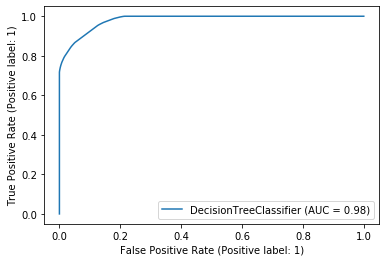

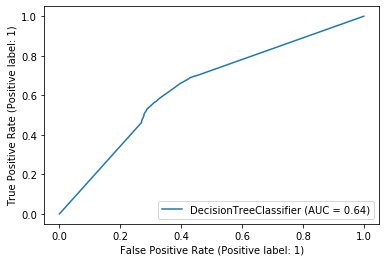

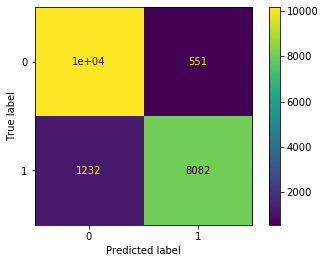

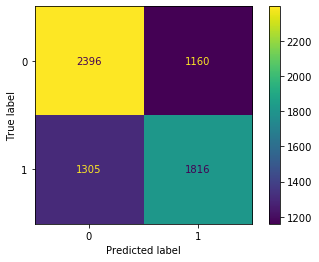

In [54]:
# let's do another model!

tree = DecisionTreeClassifier()

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# yikes, that's really overfit!  let's prune the tree

ROC Scores
Train: 0.7679592086968182
Test: 0.771651200600886


Accuracy Scores
Train: 0.7090863704443335
Test: 0.7076531376366632


F1 Scores
Train: 0.6774782753085736
Test: 0.68


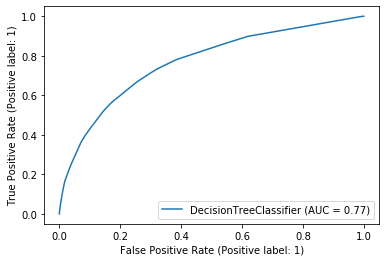

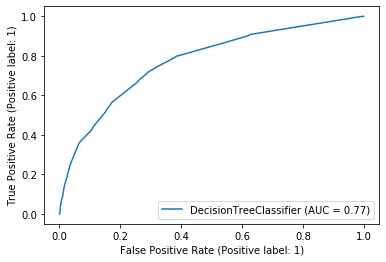

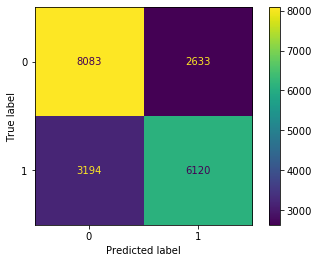

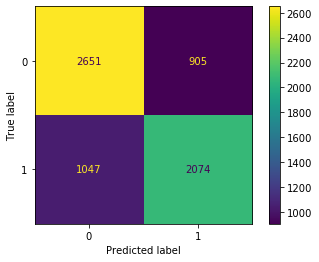

In [55]:
# tune tree parameters to reduce overfitting

tree = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, max_features=40, criterion='gini')

ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree)

# better, but not better than logreg

In [56]:
# although a tree is not the final model, check feature importances

tree.feature_importances_

array([5.65825848e-01, 1.26534211e-02, 8.08841488e-02, 1.37327994e-02,
       2.38691016e-02, 1.66714547e-02, 0.00000000e+00, 0.00000000e+00,
       1.48916960e-02, 4.18311975e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.87895523e-03, 0.00000000e+00, 0.00000000e+00,
       1.26728399e-02, 0.00000000e+00, 2.35785726e-03, 3.37099670e-02,
       1.77689711e-01, 1.44417305e-02, 0.00000000e+00, 2.54715543e-03,
       1.01360521e-03, 8.61048999e-03, 1.40286516e-03, 0.00000000e+00,
       0.00000000e+00, 1.39972367e-03, 4.03316147e-04, 1.11312385e-03,
       5.32854601e-04, 0.00000000e+00, 1.09788737e-03, 0.00000000e+00,
       8.23442857e-04, 1.95831513e-03, 0.00000000e+00, 1.39118589e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.24338457e-03])

In [57]:
ut.order_features(tree.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.56580,0.56580
age_group_65+ Years,0.17770,0.17770
health_worker,0.08090,0.08090
age_group_55 - 64 Years,0.03370,0.03370
ind_cat_1,0.02390,0.02390
ind_cat_2,0.01670,0.01670
ind_cat_5,0.01490,0.01490
race_Black,0.01440,0.01440
health_insurance,0.01370,0.01370
chronic_med_condition,0.01270,0.01270


### Tree with grid search

In [58]:
tree_param_grid = {'criterion': ['gini', 'entropy'],
                 'max_depth': [None, 4, 6, 8],
                 'min_samples_leaf': [10, 12, 14],
                 'min_samples_split': [8, 10, 12],
                  'max_features': [30, 37, 45]}
                 
tree_grid_search = GridSearchCV(tree, tree_param_grid, cv=3)
tree_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {tree_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {tree_grid_search.best_params_}")

Training Accuracy: 70.53%

Optimal Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 45, 'min_samples_leaf': 12, 'min_samples_split': 12}


ROC Scores
Train: 0.7661927366261726
Test: 0.7731394497667927


Accuracy Scores
Train: 0.7081377933100349
Test: 0.7103489591133743


F1 Scores
Train: 0.6796361245067953
Test: 0.6845024469820554


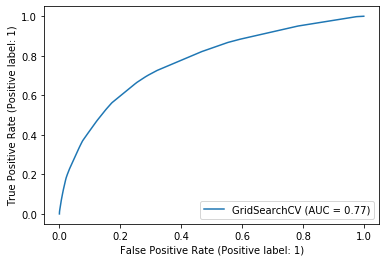

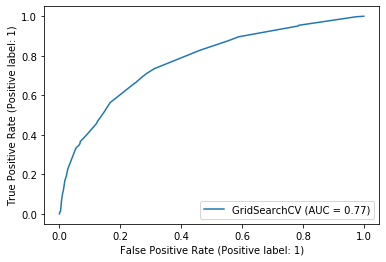

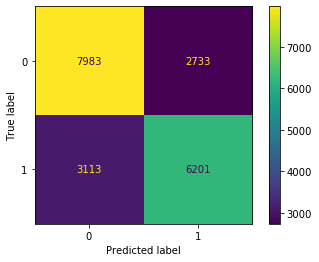

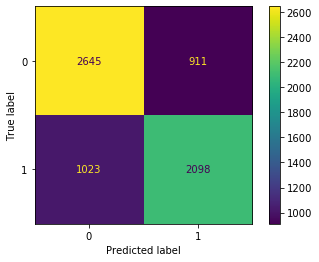

In [59]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, tree_grid_search)

In [60]:
# check grid search tree features importances

tree_grid_search.best_estimator_.feature_importances_

array([5.48753123e-01, 1.05021739e-02, 8.37507244e-02, 1.42146462e-02,
       0.00000000e+00, 7.91740525e-03, 0.00000000e+00, 7.41005511e-03,
       0.00000000e+00, 3.38651949e-03, 2.56008889e-02, 7.99382761e-03,
       0.00000000e+00, 8.66281242e-04, 0.00000000e+00, 4.49646936e-03,
       4.54362699e-02, 0.00000000e+00, 0.00000000e+00, 1.29246728e-02,
       1.88549880e-01, 4.40205715e-03, 0.00000000e+00, 1.35383889e-02,
       4.78721393e-04, 7.50163172e-04, 5.55224067e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.59515817e-04, 4.85932846e-04, 0.00000000e+00, 1.55891234e-03,
       1.82659274e-03, 0.00000000e+00, 1.98644171e-04, 1.94120308e-03,
       0.00000000e+00, 8.77128186e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.92756257e-03])

In [61]:
# doctor_recc_seasonal, age groups, and health_insurance still near the top

ut.order_features(tree_grid_search.best_estimator_.feature_importances_, X_train_nans)

,weight,abs_weight
doctor_recc_seasonal,0.54880,0.54880
age_group_65+ Years,0.18850,0.18850
health_worker,0.08380,0.08380
age_group_18 - 34 Years,0.04540,0.04540
occ_cat_1,0.02560,0.02560
health_insurance,0.01420,0.01420
race_White,0.01350,0.01350
age_group_55 - 64 Years,0.01290,0.01290
chronic_med_condition,0.01050,0.01050
occ_cat_2,0.00800,0.00800


### Bagged Decision Tree

In [62]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)
bagged_tree.fit(X_train_nans, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

ROC Scores
Train: 0.7714886060575165
Test: 0.779329825641388


Accuracy Scores
Train: 0.7105341987019471
Test: 0.7124457091508163


F1 Scores
Train: 0.6897142245531415
Test: 0.6948506039415131


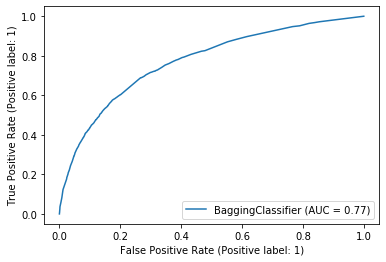

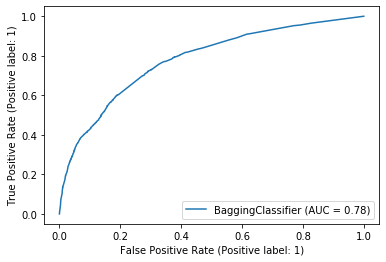

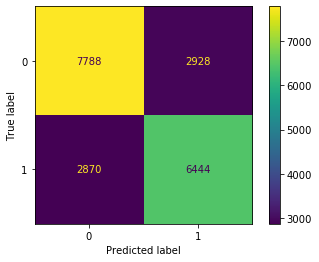

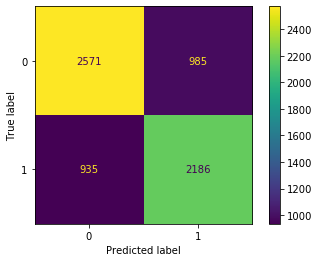

In [63]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, bagged_tree)

# not better than logreg

### Random Forest

In [64]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train_nans, y_train)

RandomForestClassifier(max_depth=5)

ROC Scores
Train: 0.7715215640653176
Test: 0.7784783420415928


Accuracy Scores
Train: 0.710134797803295
Test: 0.7088512805152014


F1 Scores
Train: 0.6720885575511126
Test: 0.6734968088679878


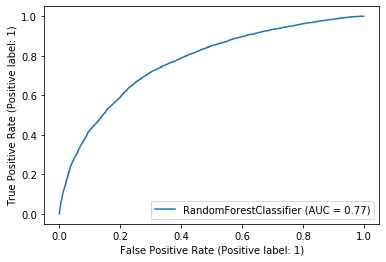

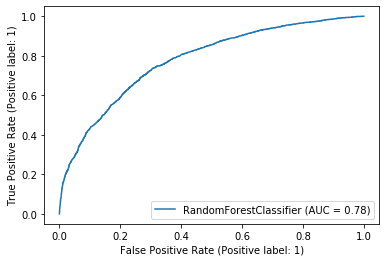

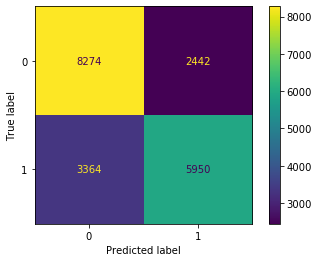

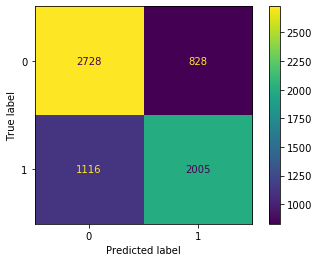

In [65]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, forest)

# no change.  Try grid search with random forest.

In [66]:
rf_param_grid = {'n_estimators': [50, 100],
                 'criterion': ['gini', 'entropy'],
                 'max_depth': [6, 10, 14],
                 'min_samples_leaf': [3, 6, 9],
                'min_samples_split': [5, 10, 15]}
                 
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_nans, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")



Training Accuracy: 70.96%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 50}


ROC Scores
Train: 0.7765541952483079
Test: 0.7832019585744668


Accuracy Scores
Train: 0.7132301547678482
Test: 0.7097498876741052


F1 Scores
Train: 0.6773396247612627
Test: 0.6751592356687899


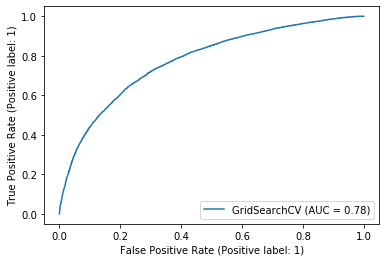

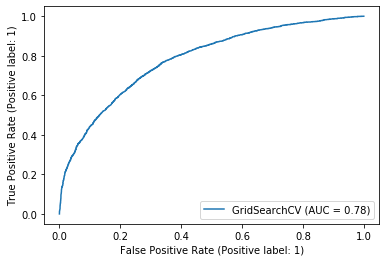

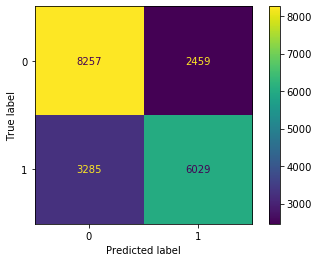

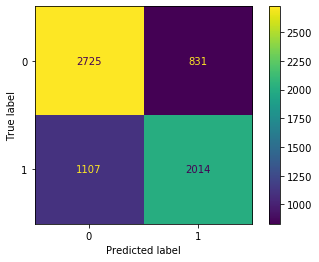

In [67]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, rf_grid_search)

# overfit, test set not better than logreg

### XGBoost Tree

In [68]:
XGB = XGBClassifier()

# Fit XGBClassifier
XGB.fit(X_train_nans, y_train)


XGBClassifier()

ROC Scores
Train: 0.7828303888241384
Test: 0.7874675760451444


Accuracy Scores
Train: 0.7155267099350974
Test: 0.7131945484499026


F1 Scores
Train: 0.6849148418491484
Test: 0.6828945189600927


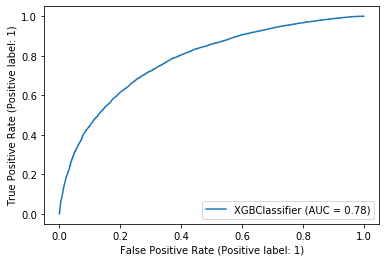

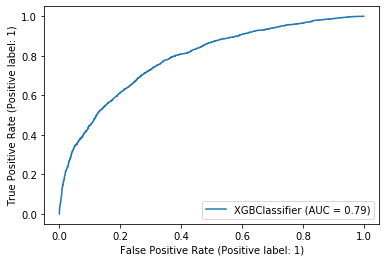

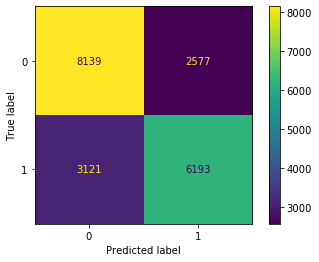

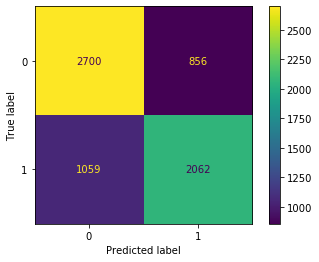

In [69]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, XGB)
# less overfit
# similar to logreg

### XGBoost Tree with Grid Search

In [70]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 8],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100]}

In [71]:
grid_XGB = GridSearchCV(XGB, xgb_param_grid, cv=None, n_jobs=1)
grid_XGB.fit(X_train_nans, y_train)


GridSearchCV(estimator=XGBClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [6, 8],
                         'min_child_weight': [1, 2], 'n_estimators': [100],
                         'subsample': [0.5, 0.7]})

ROC Scores
Train: 0.8167206338389479
Test: 0.782053672119886


Accuracy Scores
Train: 0.7383424862705941
Test: 0.71499176276771


F1 Scores
Train: 0.709591621876212
Test: 0.6863359156090325


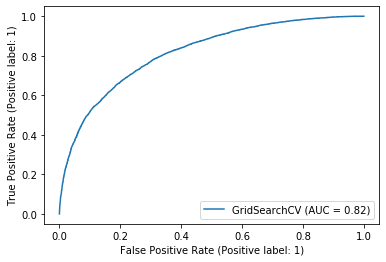

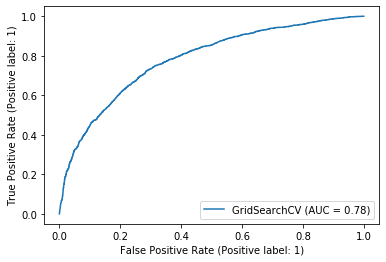

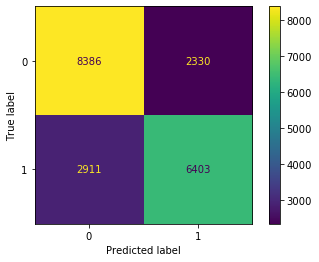

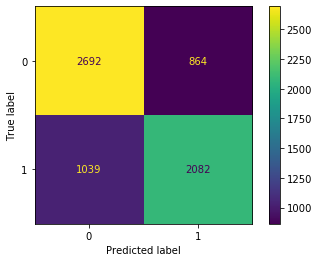

In [72]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, grid_XGB)
# overfit
# not better... try different parameters?

### XGBoost Tree with Dart Booster and Grid Search

In [73]:
XGB_dart = XGBClassifier(booster='dart')

# Fit XGBClassifier dart
XGB_dart.fit(X_train_nans, y_train)

XGBClassifier(booster='dart')

In [74]:
grid_XGB_dart = GridSearchCV(XGB_dart, xgb_param_grid, cv=None, n_jobs=1)
grid_XGB_dart.fit(X_train_nans, y_train)

GridSearchCV(estimator=XGBClassifier(booster='dart'), n_jobs=1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [6, 8],
                         'min_child_weight': [1, 2], 'n_estimators': [100],
                         'subsample': [0.5, 0.7]})

ROC Scores
Train: 0.8169583583110848
Test: 0.7820943541140984


Accuracy Scores
Train: 0.7382426360459311
Test: 0.7169387449453347


F1 Scores
Train: 0.7095451775524902
Test: 0.6875000000000001


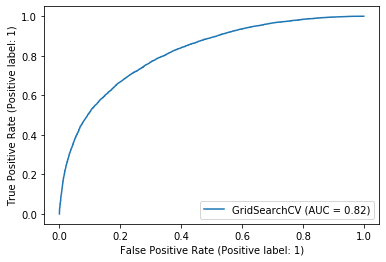

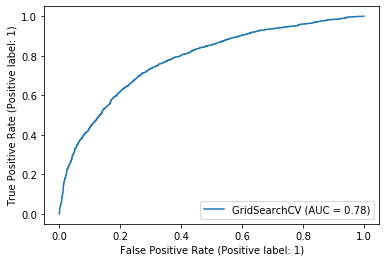

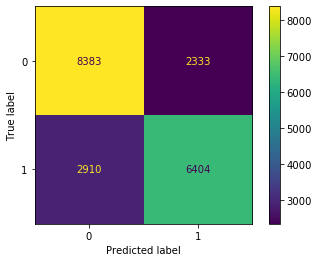

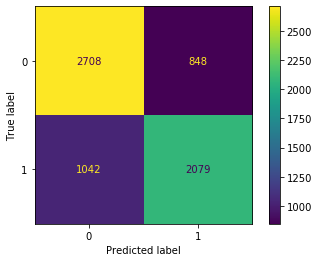

In [75]:
ut.eval_model(X_train_nans, X_test_nans, y_train, y_test, grid_XGB_dart)
# not better than logreg

### Support Vector Machine

In [76]:
SVM = SVC(kernel='linear')
SVM.fit(X_train_nans, y_train)

SVC(kernel='linear')

In [77]:
y_train_pred = SVM.predict(X_train_nans)
y_test_pred = SVM.predict(X_test_nans)

print('ROC Scores')
print('Train:', roc_auc_score(y_train, SVM.decision_function(X_train_nans)))
print('Test:', roc_auc_score(y_test, SVM.decision_function(X_test_nans)))
print('\n')
print('Accuracy Scores')
print('Train:', accuracy_score(y_train, y_train_pred))
print('Test:', accuracy_score(y_test, y_test_pred))
print('\n')
print('F1 Scores')
print('Train:', f1_score(y_train, y_train_pred))
print('Test:', f1_score(y_test, y_test_pred))

# worse scores

ROC Scores
Train: 0.7590834253292074
Test: 0.7777393984435059


Accuracy Scores
Train: 0.6846729905142287
Test: 0.6935749588138386


F1 Scores
Train: 0.6064797507788162
Test: 0.6161350844277674


## Conclusion

### Recommendations

All the models rank the 'doctor_recc_seasonal' variable as the most important feature influencing vaccination.  This suggests that reaching out to patients who have not had a doctor visit during flu season may improve vaccination rates.  It also implies that patients trust their doctors and respond well to their advice.

All models also rank the health insurance and 'census_msa_Non-MSA' features in the top ten.  The latter is a [census designation](https://www.census.gov/programs-surveys/metro-micro/about.html#:~:text=Delineating%20Metropolitan%20and%20Micropolitan%20Statistical%20Areas,-The%202010%20standards&text=Each%20metropolitan%20statistical%20area%20must,but%20less%20than%2050%2C000%20population.) meaning the respondent does not live in a metropolitan area.  The interaction between these variables is complicated, as lower vaccination rates in rural areas seem to be linked to the uninsured population there.  Lovelace should prioritize their uninsured population for outreach, with a secondary focus on rural patients in general.  

Finally, it appears that young people are less likely to get the flu vaccine, and that Lovelace should target 18-34-year-olds if they want to boost population immunity.

### Future Work

Much work remains to paint a clearer picture of which patients are unlikely to get the flu vaccine.  It would be helpful to have data that is more representative of all demographic groups.

There are also many ways experiment with making the model more sophisticated.  Removing features which influence each other (such as rural and uninsured) may clarify which other features are important.  Also, a few geographic and occupational categories have very low values, and eliminating these categories altogether may improve the model.  Finally, It may be worthwhile to try deleting rows with null values to see if that sharpens the model.  